In [1]:
import pandas as pd
import numpy as np

def optimistic_majority_sorting(data, weights, limiting_profiles, lambda_values):
    # Normalize data based on criteria type
    criteria_to_minimize = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]
    for col in criteria_to_minimize:
        data[col] = 10 - data[col]

    criteria_to_maximize = ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]
    for col in criteria_to_maximize:
        data[col] = 2 * data[col]

    # Prepare profiles in a structured format
    relevant_columns = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)", "Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]
    profiles = {k: np.array([v[c] for c in relevant_columns]) for k, v in limiting_profiles.items()}

    # Compute concordance indices
    def concordance(a, b, weights):
        return np.sum([weights[i] for i in range(len(weights)) if a[i] >= b[i]])

    # Assign categories using the optimistic approach
    def assign_category(food, profiles, lambda_threshold, weights):
        for category, profile in profiles.items():
            if concordance(profile, food, weights) >= lambda_threshold:
                return category
        return "E"  # Default to the worst category if no match is found

    # Process each food item for each lambda value
    results = []
    for lambda_threshold in lambda_values:
        for _, row in data.iterrows():
            food_name = row["Product Name"]  # Assuming "Food Name" column exists
            nutri_score = row["Nutri-Score"]  # Keep the Nutri-Score column
            food = row[relevant_columns].values
            category = assign_category(food, profiles, lambda_threshold, weights)
            results.append({"Product Name": food_name, "Nutri-Score": nutri_score, "Category": category, "Lambda": lambda_threshold})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

# Example usage
file_path = "data_nutrition_score.xlsx"
data = pd.read_excel(file_path)

weights = [0.4, 0.3, 0.3, 0.3, 0.2, 0.2, 0.1]  # Example weights
limiting_profiles = {
    "A": {"Energy (kcal)": 335, "Sugars (g)": 5, "Saturated Fat (g)": 1, "Salt (g)": 0.1, "Proteins (g)": 8, "Fiber (g)": 10, "Fruits/Vegetables (%)": 40},
    "B": {"Energy (kcal)": 400, "Sugars (g)": 10, "Saturated Fat (g)": 2, "Salt (g)": 0.3, "Proteins (g)": 6, "Fiber (g)": 8, "Fruits/Vegetables (%)": 20},
    "C": {"Energy (kcal)": 500, "Sugars (g)": 15, "Saturated Fat (g)": 3, "Salt (g)": 0.5, "Proteins (g)": 4, "Fiber (g)": 5, "Fruits/Vegetables (%)": 10},
    "D": {"Energy (kcal)": 700, "Sugars (g)": 20, "Saturated Fat (g)": 5, "Salt (g)": 1.0, "Proteins (g)": 2, "Fiber (g)": 3, "Fruits/Vegetables (%)": 5},
    "E": {"Energy (kcal)": 900, "Sugars (g)": 30, "Saturated Fat (g)": 8, "Salt (g)": 2.0, "Proteins (g)": 0, "Fiber (g)": 0, "Fruits/Vegetables (%)": 0},
}
lambda_values = [0.5, 0.6, 0.7]  # Test for multiple lambda thresholds

# Run the function
results = optimistic_majority_sorting(data, weights, limiting_profiles, lambda_values)

# Save results to an Excel file
#output_file = "classified_foods_with_nutri_score_and_lambda.xlsx"
#results.to_excel(output_file, index=False)
#print(f"Results saved to {output_file}")


In [2]:
results

,Product Name,Nutri-Score,Category,Lambda
0,cruesly mélange de noix,a,A,0.5
1,Céréales Chocapic,a,A,0.5
2,Flocons d'avoine,a,A,0.5
3,Haferflocken,a,A,0.5
4,Weetabix,a,A,0.5
...,...,...,...,...
2824,All-bran,a,A,0.7
2825,All-Bran Original,b,A,0.7
2826,Clusters,c,A,0.7
2827,Bamboo,a,A,0.7


In [3]:
results["Nutri-Score"] = results["Nutri-Score"].str.upper()

In [4]:
results

,Product Name,Nutri-Score,Category,Lambda
0,cruesly mélange de noix,A,A,0.5
1,Céréales Chocapic,A,A,0.5
2,Flocons d'avoine,A,A,0.5
3,Haferflocken,A,A,0.5
4,Weetabix,A,A,0.5
...,...,...,...,...
2824,All-bran,A,A,0.7
2825,All-Bran Original,B,A,0.7
2826,Clusters,C,A,0.7
2827,Bamboo,A,A,0.7


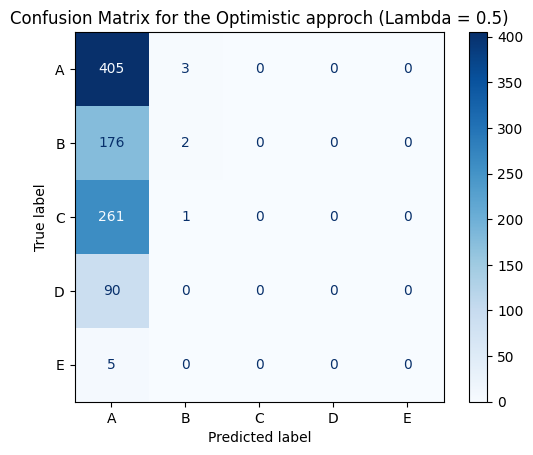

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = results[results["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri-Score"]
y_pred = subset["Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for the Optimistic approch (Lambda = {lambda_to_analyze})")
plt.show()

## using segmentation approach (quantile approach) to find limiting profiles:

In [6]:
#using segmentation approach (quantile approach) to find limiting profiles:
columns_to_min = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]
columns_to_max = ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]

quintiles_min = data[columns_to_min].quantile([0.2, 0.4, 0.6, 0.8])
quintiles_max = data[columns_to_max].quantile([0.2, 0.4, 0.6, 0.8])

print(quintiles_min)
print(quintiles_max)

     Energy (kcal)  Sugars (g)  Saturated Fat (g)  Salt (g)
0.2         -433.0  -12.000000                6.2    9.3400
0.4         -391.2   -7.673333                8.0    9.7200
0.6         -370.0   -3.580000                8.8    9.9234
0.8         -359.0    4.380000                9.4    9.9800
     Proteins (g)  Fiber (g)  Fruits/Vegetables (%)
0.2          16.0       11.0                  0.000
0.4          18.0       14.0                  0.000
0.6          20.0       17.0                  3.175
0.8          24.0       20.0                 25.960


In [7]:
limiting_profiles_2 = {
    "A": {**quintiles_min.loc[0.2].to_dict(), **data[columns_to_max].max().to_dict()},  # Min Q1 + Max valeurs
    "B": {**quintiles_min.loc[0.4].to_dict(), **quintiles_max.loc[0.8].to_dict()},     # Min Q2 + Max Q4
    "C": {**quintiles_min.loc[0.6].to_dict(), **quintiles_max.loc[0.6].to_dict()},     # Min Q3 + Max Q3
    "D": {**quintiles_min.loc[0.8].to_dict(), **quintiles_max.loc[0.4].to_dict()},     # Min Q4 + Max Q2
    "E": {**data[columns_to_min].max().to_dict(), **quintiles_max.loc[0.2].to_dict()}  # Max valeurs + Min Q1
}
limiting_profiles

{'A': {'Energy (kcal)': 335,
  'Sugars (g)': 5,
  'Saturated Fat (g)': 1,
  'Salt (g)': 0.1,
  'Proteins (g)': 8,
  'Fiber (g)': 10,
  'Fruits/Vegetables (%)': 40},
 'B': {'Energy (kcal)': 400,
  'Sugars (g)': 10,
  'Saturated Fat (g)': 2,
  'Salt (g)': 0.3,
  'Proteins (g)': 6,
  'Fiber (g)': 8,
  'Fruits/Vegetables (%)': 20},
 'C': {'Energy (kcal)': 500,
  'Sugars (g)': 15,
  'Saturated Fat (g)': 3,
  'Salt (g)': 0.5,
  'Proteins (g)': 4,
  'Fiber (g)': 5,
  'Fruits/Vegetables (%)': 10},
 'D': {'Energy (kcal)': 700,
  'Sugars (g)': 20,
  'Saturated Fat (g)': 5,
  'Salt (g)': 1.0,
  'Proteins (g)': 2,
  'Fiber (g)': 3,
  'Fruits/Vegetables (%)': 5},
 'E': {'Energy (kcal)': 900,
  'Sugars (g)': 30,
  'Saturated Fat (g)': 8,
  'Salt (g)': 2.0,
  'Proteins (g)': 0,
  'Fiber (g)': 0,
  'Fruits/Vegetables (%)': 0}}

In [8]:
results_quantile_approch = optimistic_majority_sorting(data, weights, limiting_profiles_2, lambda_values)
results_quantile_approch["Nutri-Score"] = results["Nutri-Score"].str.upper()
results_quantile_approch

,Product Name,Nutri-Score,Category,Lambda
0,cruesly mélange de noix,A,A,0.5
1,Céréales Chocapic,A,A,0.5
2,Flocons d'avoine,A,A,0.5
3,Haferflocken,A,A,0.5
4,Weetabix,A,A,0.5
...,...,...,...,...
2824,All-bran,A,A,0.7
2825,All-Bran Original,B,A,0.7
2826,Clusters,C,A,0.7
2827,Bamboo,A,A,0.7


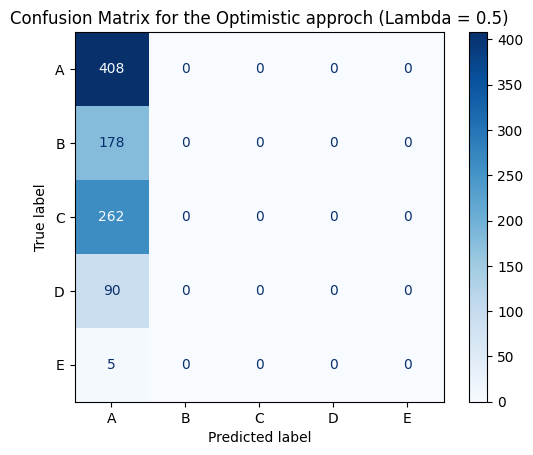

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = results_quantile_approch[results_quantile_approch["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri-Score"]
y_pred = subset["Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for the Optimistic approch (Lambda = {lambda_to_analyze})")
plt.show()

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

In [14]:
lambda_to_analyze = 0.5
subset = results_quantile_approch[results_quantile_approch["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri-Score"]
y_pred = subset["Category"]

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and print precision
precision = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision:.2f}")

# Calculate and print recall
recall = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall:.2f}")

# Calculate and print F1 score
f1 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.43
Precision: 0.09
Recall: 0.20
F1 Score: 0.12


/opt/homebrew/Cellar/jupyterlab/4.3.1_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Machine learning part :

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

X = data.drop(["Nutri-Score","Brand","Category","Eco-Score"], axis=1)

y = data["Nutri-Score"]

y = y.str.upper()

# Encode target labels into numerical values (if not already encoded)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Scale the features
scaler = StandardScaler()

X_train[["Energy (kcal)","Sugars (g)","Saturated Fat (g)","Salt (g)","Fiber (g)","Fiber (g)","Proteins (g)","Fruits/Vegetables (%)"]] = scaler.fit_transform(X_train[["Energy (kcal)","Sugars (g)","Saturated Fat (g)","Salt (g)","Fiber (g)","Fiber (g)","Proteins (g)","Fruits/Vegetables (%)"]])
X_test[["Energy (kcal)","Sugars (g)","Saturated Fat (g)","Salt (g)","Fiber (g)","Fiber (g)","Proteins (g)","Fruits/Vegetables (%)"]] = scaler.transform(X_test[["Energy (kcal)","Sugars (g)","Saturated Fat (g)","Salt (g)","Fiber (g)","Fiber (g)","Proteins (g)","Fruits/Vegetables (%)"]])


In [ ]:
X_test.shape

(283, 8)

In [ ]:
# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train[["Energy (kcal)","Sugars (g)","Saturated Fat (g)","Salt (g)","Fiber (g)","Fiber (g)","Proteins (g)","Fruits/Vegetables (%)"]], y_train)

# Predict with Decision Tree
dt_predictions = dt_classifier.predict(X_test[["Energy (kcal)","Sugars (g)","Saturated Fat (g)","Salt (g)","Fiber (g)","Fiber (g)","Proteins (g)","Fruits/Vegetables (%)"]])


In [ ]:
# Train an XGBoost Classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_classifier.fit(X_train[["Energy (kcal)","Sugars (g)","Saturated Fat (g)","Salt (g)","Fiber (g)","Fiber (g)","Proteins (g)","Fruits/Vegetables (%)"]].values, y_train)

# Predict with XGBoost
xgb_predictions  = xgb_classifier.predict(X_test[["Energy (kcal)","Sugars (g)","Saturated Fat (g)","Salt (g)","Fiber (g)","Fiber (g)","Proteins (g)","Fruits/Vegetables (%)"]].values)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Decision Tree Classification Report:
              precision    recall  f1-score   support

           A       0.89      0.88      0.88       122
           B       0.60      0.70      0.64        53
           C       0.88      0.81      0.84        79
           D       0.84      0.78      0.81        27
           E       0.33      0.50      0.40         2

    accuracy                           0.81       283
   macro avg       0.71      0.73      0.72       283
weighted avg       0.82      0.81      0.82       283



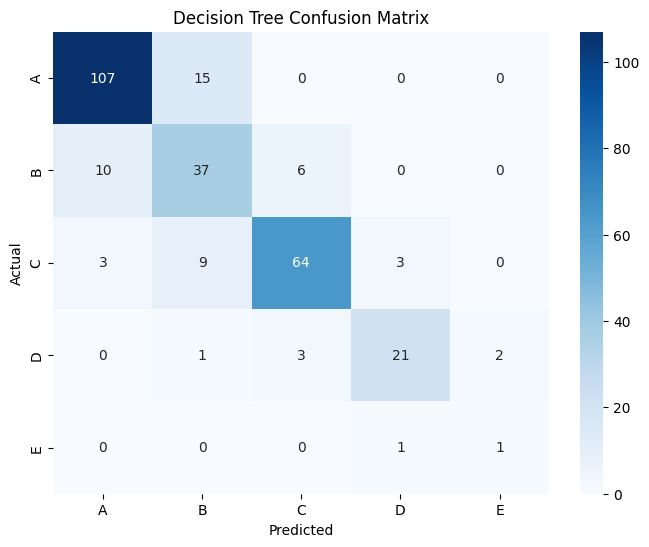

In [ ]:
# Labels for the confusion matrix
labels = label_encoder.classes_

# Decision Tree Results
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_predictions, target_names=labels))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, dt_predictions, title="Decision Tree Confusion Matrix", labels=labels)


In [ ]:
# Generate the classification report as a dictionary
report_dict = classification_report(y_test, dt_predictions, target_names=labels, output_dict=True)

# Convert the dictionary to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Display the DataFrame
Dreport_df

,precision,recall,f1-score,support
A,0.891667,0.877049,0.884298,122.000000
B,0.596774,0.698113,0.643478,53.000000
C,0.876712,0.810127,0.842105,79.000000
D,0.840000,0.777778,0.807692,27.000000
E,0.333333,0.500000,0.400000,2.000000
accuracy,0.812721,0.812721,0.812721,0.812721
macro avg,0.707697,0.732613,0.715515,283.000000
weighted avg,0.823390,0.812721,0.816688,283.000000


XGBoost Classification Report:
              precision    recall  f1-score   support

           A       0.97      0.93      0.95       122
           B       0.73      0.85      0.78        53
           C       0.91      0.87      0.89        79
           D       0.88      0.85      0.87        27
           E       1.00      0.50      0.67         2

    accuracy                           0.89       283
   macro avg       0.90      0.80      0.83       283
weighted avg       0.90      0.89      0.89       283



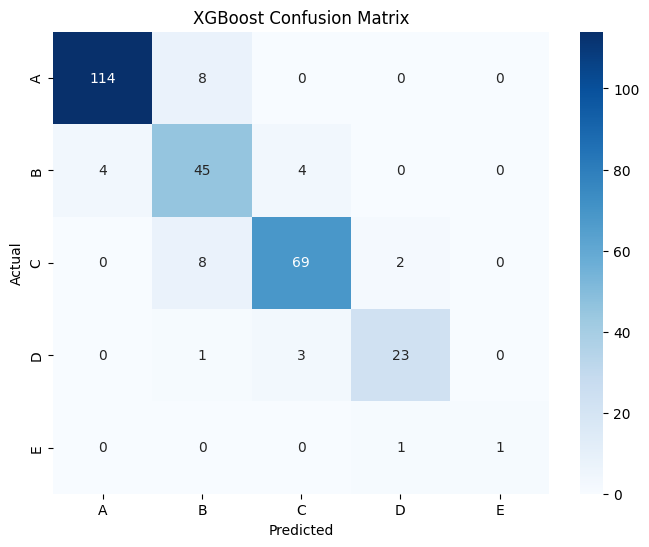

In [ ]:
# XGBoost Results
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions, target_names=labels))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, xgb_predictions, title="XGBoost Confusion Matrix", labels=labels)


In [ ]:
# Generate the classification report as a dictionary
report_dict = classification_report(y_test, xgb_predictions, target_names=labels, output_dict=True)

# Convert the dictionary to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Display the DataFrame
report_df

,precision,recall,f1-score,support
A,0.966102,0.934426,0.950000,122.000000
B,0.725806,0.849057,0.782609,53.000000
C,0.907895,0.873418,0.890323,79.000000
D,0.884615,0.851852,0.867925,27.000000
E,1.000000,0.500000,0.666667,2.000000
accuracy,0.890459,0.890459,0.890459,0.890459
macro avg,0.896884,0.801750,0.831504,283.000000
weighted avg,0.897316,0.890459,0.892159,283.000000
